# Customer Sentiment Analysis
by Ethan Huffman

### Business Understanding

Companies receive thousands of tweets every day about their products and brands. Manually reviewing this volume of feedback is inefficient and makes it easy to miss important negative sentiment that could signal product issues, customer dissatisfaction, or emerging brand risks.

The goal of this project is to build a machine learning model that can automatically classify tweet sentiment so stakeholders can quickly prioritize feedback that requires attention. By identifying negative sentiment early, product, marketing, and customer support teams can respond faster to potential issues and make more informed decisions based on public customer feedback.


### Data Understanding

The dataset used in this project comes from CrowdFlower (via data.world) and contains over 9,000 tweets related to brands and products. Each tweet was labeled by human reviewers as expressing positive emotion, negative emotion, no emotion toward a brand or product, or uncertainty.

For this proof of concept, the analysis focuses only on tweets with clear positive or negative sentiment. After filtering, the modeling dataset contains 3,548 tweets, with approximately 84% positive sentiment and 16% negative sentiment. This imbalance is important because negative feedback is more costly for a business to miss.

Tweets are short and informal, which introduces limitations such as sarcasm and lack of context. Additionally, Twitter users may not represent all customers, so results should be interpreted as an indicator of public sentiment rather than a complete measure of customer satisfaction.


### Data Analysis

In [31]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [32]:
df = pd.read_csv(
    "data/judge-1377884607_tweet_product_company.csv",
    encoding="latin-1"
)

df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


This step brings the Twitter data into the project so it can be reviewed and analyzed. It ensures that all tweets and their sentiment labels are available for the model to learn from.


In [33]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts(dropna=False)


is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

This step shows how many tweets are positive, negative, or unclear. Understanding this balance helps explain why some types of feedback are harder to detect and why certain modeling choices are necessary.


In [34]:
df_binary = df[
    df["is_there_an_emotion_directed_at_a_brand_or_product"].isin(
        ["Positive emotion", "Negative emotion"]
    )
].copy()

df_binary["sentiment"] = df_binary[
    "is_there_an_emotion_directed_at_a_brand_or_product"
].map({
    "Positive emotion": 1,
    "Negative emotion": 0
})

df_binary["sentiment"].value_counts()


sentiment
1    2978
0     570
Name: count, dtype: int64

This step narrows the analysis to tweets with clearly positive or negative sentiment. This keeps the project focused on feedback that can directly inform business decisions and avoids ambiguity.


In [35]:
X = df_binary["tweet_text"]
y = df_binary["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.value_counts(normalize=True)


sentiment
1    0.839323
0    0.160677
Name: proportion, dtype: float64

This step separates the data into two groups: one for training the model and one for testing it. This allows us to check how well the model performs on new, unseen tweets rather than just the data it learned from.


### Modeling

In [36]:
baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

baseline_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

This step creates an initial version of the model to set a performance baseline. The purpose of this model is not to be perfect, but to establish a starting point so we can understand how well a simple approach performs before making improvements.


In [37]:
y_pred = baseline_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.09      0.16       114
           1       0.85      1.00      0.92       596

    accuracy                           0.85       710
   macro avg       0.88      0.54      0.54       710
weighted avg       0.86      0.85      0.80       710



This step evaluates how well the initial model performs. It shows how often the model correctly identifies positive and negative tweets, helping us understand where the model performs well and where it struggles.


In [38]:
weighted_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("logreg", LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight="balanced"
    ))
])

weighted_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

This step improves the model by placing more emphasis on correctly identifying negative sentiment. Missing negative feedback is more costly for a business, so this adjustment helps the model better capture those important cases.


In [39]:
y_pred_weighted = weighted_model.predict(X_test)
print(classification_report(y_test, y_pred_weighted))


              precision    recall  f1-score   support

           0       0.49      0.65      0.56       114
           1       0.93      0.87      0.90       596

    accuracy                           0.83       710
   macro avg       0.71      0.76      0.73       710
weighted avg       0.86      0.83      0.84       710



This step evaluates the improved model and allows us to compare it against the baseline. The goal is to confirm that the changes lead to better detection of negative sentiment without sacrificing too much overall accuracy.


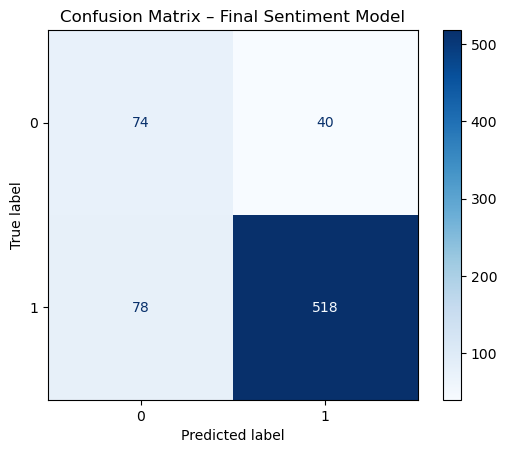

In [40]:
ConfusionMatrixDisplay.from_estimator(
    weighted_model,
    X_test,
    y_test,
    cmap="Blues"
)

plt.title("Confusion Matrix – Final Sentiment Model")
plt.show()


This visualization shows where the model makes correct predictions and where it makes mistakes. It provides an intuitive way to understand how often negative or positive tweets are misclassified.


In [41]:
proba_pos = weighted_model.predict_proba(X_test)[:, 1]

results = pd.DataFrame({
    "tweet_text": X_test.values,
    "true_sentiment": y_test.values,
    "predicted_sentiment": y_pred_weighted,
    "proba_positive": proba_pos
})

results["proba_negative"] = 1 - results["proba_positive"]

results.sort_values("proba_negative", ascending=False).head(15)


,tweet_text,true_sentiment,predicted_sentiment,proba_positive,proba_negative
106,I just watched &quot;iPad Design Headaches&quo...,0,0,0.077518,0.922482
153,Barry Diller says that you're silly if you wri...,0,0,0.099390,0.900610
46,#SXSW 2011: Novelty of iPad news apps fades fa...,0,0,0.115140,0.884860
625,ÛÏThe classiest fascist company in existence...,0,0,0.117683,0.882317
528,#SXSW 2011: Novelty of #iPad news apps fades f...,0,0,0.136862,0.863138
667,@mention - #Apple is the classiest fascist com...,0,0,0.144690,0.855310
39,#sxsw is exposing my iphone's horrendous batte...,0,0,0.146032,0.853968
223,ÛÏ@mention Best thing I've heard this weekend...,0,0,0.163102,0.836898
140,RT @mention Best thing I've heard this weekend...,0,0,0.164406,0.835594
421,I've never been surrounded by so many #iPhone ...,1,0,0.164542,0.835458


This step highlights tweets that the model is most confident are negative. This helps stakeholders quickly identify the feedback that may require immediate attention.


In [42]:
joblib.dump(weighted_model, "final_sentiment_model.joblib")

loaded_model = joblib.load("final_sentiment_model.joblib")

new_tweets = pd.Series([
    "I love my new iPad, it's amazing!",
    "This phone battery is horrible and keeps dying."
])

preds = loaded_model.predict(new_tweets)
proba_pos = loaded_model.predict_proba(new_tweets)[:, 1]

pd.DataFrame({
    "tweet": new_tweets,
    "predicted_sentiment": preds,
    "prob_positive": proba_pos,
    "prob_negative": 1 - proba_pos
})


,tweet,predicted_sentiment,prob_positive,prob_negative
0,"I love my new iPad, it's amazing!",1,0.835241,0.164759
1,This phone battery is horrible and keeps dying.,0,0.144157,0.855843


This step demonstrates how the model can be used in practice. New tweets can be entered, and the model returns both a sentiment classification and a confidence score, showing how it could be applied in a real business setting.


In [43]:
import joblib

joblib.dump(weighted_model, "final_sentiment_model.joblib")


['final_sentiment_model.joblib']

### Conclusion

This project demonstrates that an NLP-based sentiment model can effectively classify customer sentiment from Twitter data. By prioritizing the detection of negative sentiment, the final model supports faster identification of potential customer issues.

While the model is not perfect and should not replace human judgment, it provides a scalable way for businesses to monitor public feedback and focus attention where it is most needed. Future improvements could include handling neutral sentiment, expanding to additional platforms, or incorporating sarcasm detection.
